In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats
import szutils

import jax; jax.config.update('jax_enable_x64',True)
import jax.numpy as jp
import jax.scipy as js
import jax_finufft

import corner
import numpyro
import numpyro.distributions as dist

from astropy import units as u

In [23]:
fields  = np.arange(1,8)
spws    = {field: np.arange(4) for field in fields}
arrays  = [com12m']

refname = '/Users/ldimasco/Documents/Data/ALMA/RXJ1347/{0}/{1}/splits/RXJ1347_calibrated_{0}_{1}.raw'

In [24]:
# Load data
# ----------------------------------------------------------

visdict = {}
for bi, band in enumerate(['band3']):
    visdict[band] = {}
    for ai, array in enumerate(arrays):
        visdict[band].update({array: {field: {} for field in fields}})
        
        for fi, field in enumerate(fields):
            for si, spw in enumerate(spws[field]):
                spwname = refname.format(band,array)+f'.field-{field}.spw-{spw}'
                spwdata = szutils.loadvis(spwname)

                print(np.rad2deg(1.00/np.hypot(spwdata.u,spwdata.v).min())*60*60)
                
                spwdata.wt /= 100.00
                spwbeam = szutils.loadpb(spwname)

                visdict[band][array][field][spw] = dict(data   = spwdata,
                                                        beam   = jp.array(spwbeam.data.copy()),
                                                        header = spwbeam.header.copy(),
                                                        norm   = jp.sum(jp.log(spwdata.wt/2.00/jp.pi)))

plt.imshow(visdict['band3']['com12m'][3][0]['beam'])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ldimasco/Documents/Data/ALMA/RXJ1347/band3/com07/splits/RXJ1347_calibrated_band3_com07.raw.field-1.spw-0.data.npz'

In [4]:
xref =  (13.00+(47.00+30.54/60.00)/60.00)*15.00
yref = -(11.00+(45.00+19.40/60.00)/60.00)

rref = 3.00E+01/3.60E+03
fref = 9.00E+10

def model():
    ps_xpos = numpyro.sample('ps_xpos',dist.Uniform(low=xref-rref,high=xref+rref))
    ps_ypos = numpyro.sample('ps_ypos',dist.Uniform(low=yref-rref,high=yref+rref))
    
    ps_flux = numpyro.sample('ps_flux',dist.Uniform(low=-6.00,high=0.00))
    ps_spix = numpyro.sample('ps_spix',dist.Uniform(low=-3.00,high=10.00))
    
    for band in ['band3']:
        for array in ['com12m']:
            for fi, field in enumerate(fields):
                # gnfw
                for si, spw in enumerate(spws[field]):
                    spwdict = visdict[band][array][field][spw]
                    dx = jp.deg2rad(ps_xpos-spwdict['header']['CRVAL1'])*jp.cos(jp.deg2rad(spwdict['header']['CRVAL2']))
                    dy = jp.deg2rad(ps_ypos-spwdict['header']['CRVAL2'])

                    sphi = (2.00*jp.pi)*1j*(spwdict['data'].u*dx+spwdict['data'].v*dy)
                    smod = (10**ps_flux)*(spwdict['header']['FREQ']/fref)**ps_spix

                    di = spwdict['header']['CRPIX1']+(ps_xpos-spwdict['header']['CRVAL1'])*jp.cos(jp.deg2rad(spwdict['header']['CRVAL2']))/jp.abs(spwdict['header']['CDELT1']) 
                    dj = spwdict['header']['CRPIX2']+(ps_ypos-spwdict['header']['CRVAL2'])/spwdict['header']['CDELT2']

                    spba = js.ndimage.map_coordinates(spwdict['beam'],[[dj],[di]],1)

                    smod = smod*spba*jp.exp(sphi)

                    schi = spwdict['data'].wt*((spwdict['data'].re-smod.real)**2+(spwdict['data'].im-smod.imag)**2)

                    numpyro.factor(f'like_{array}_f{field}_s{spw}',-0.50*(jp.sum(schi)-spwdict['norm']))
                    del smod, sphi, schi
                    del spwdict

rkey = jax.random.PRNGKey(0) 
rkey, seed = jax.random.split(rkey)

kern = numpyro.infer.NUTS(model)
samp = numpyro.infer.MCMC(kern,num_warmup=1000,num_samples=1000)
samp.run(seed)

samp.print_summary()

sample: 100%|███████████████████████████████████████████████| 2000/2000 [04:45<00:00,  7.01it/s, 7 steps of size 4.79e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   ps_flux     -2.39      0.01     -2.39     -2.41     -2.38    827.84      1.00
   ps_spix     -0.38      0.32     -0.37     -0.93      0.13    735.30      1.00
   ps_xpos    206.88      0.00    206.88    206.88    206.88    923.95      1.00
   ps_ypos    -11.75      0.00    -11.75    -11.75    -11.75   1590.95      1.00

Number of divergences: 0


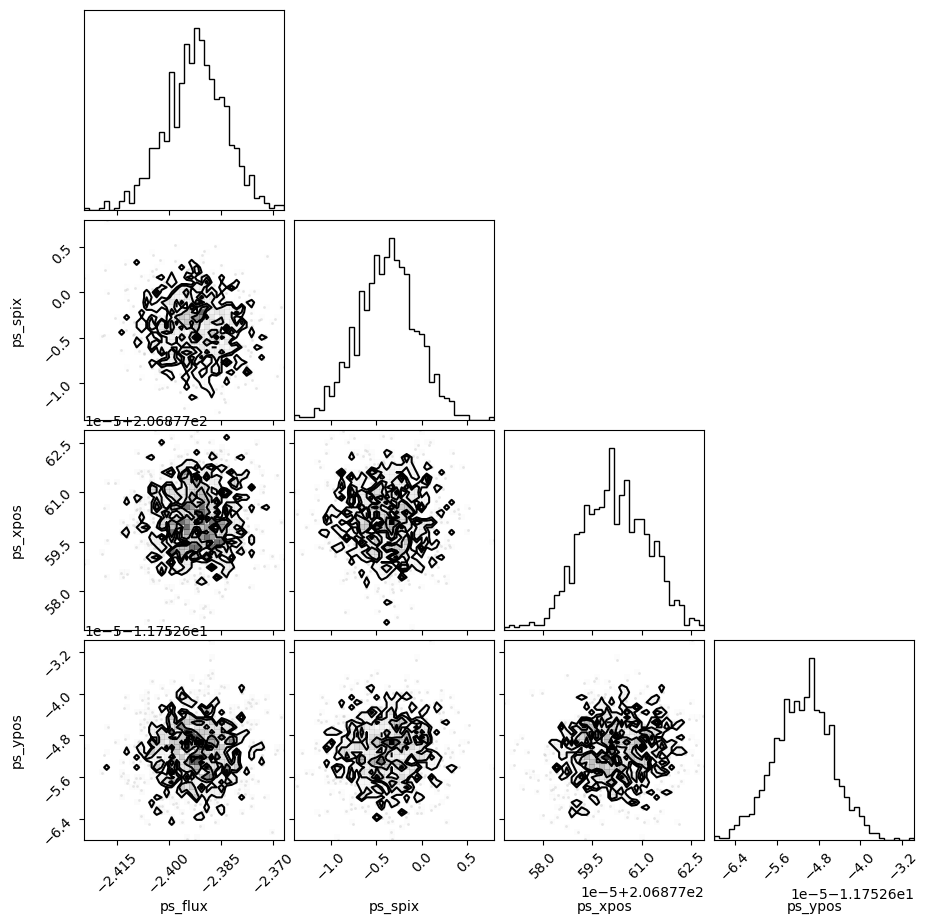

In [11]:
fig = corner.corner(samp,bins=40)

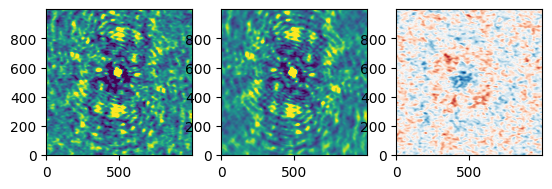

In [19]:
samples = samp.get_samples()
ps_xpos = corner.quantile(samp.get_samples()['ps_xpos'],0.50)
ps_ypos = corner.quantile(samp.get_samples()['ps_ypos'],0.50)
ps_flux = corner.quantile(samp.get_samples()['ps_flux'],0.50)
ps_spix = corner.quantile(samp.get_samples()['ps_spix'],0.50)

mout = np.array([]); xout = np.array([])
dout = np.array([]); yout = np.array([])
wout = np.array([])

for band in ['band3']:
    for array in ['com07','com12m']:
        for fi, field in enumerate([4]):
            for si, spw in enumerate(spws[field]):
                spwdict = visdict[band][array][field][spw]
                if not spwdict['data'].hermitian: spwdict['data'].doherm()

                dx = jp.deg2rad(ps_xpos-spwdict['header']['CRVAL1'])*jp.cos(jp.deg2rad(spwdict['header']['CRVAL2']))
                dy = jp.deg2rad(ps_ypos-spwdict['header']['CRVAL2'])

                sphi = (2.00*jp.pi)*1j*(spwdict['data'].u*dx+spwdict['data'].v*dy)
                smod = (10**ps_flux)*(spwdict['header']['FREQ']/fref)**ps_spix

                di = spwdict['header']['CRPIX1']+(ps_xpos-spwdict['header']['CRVAL1'])*jp.cos(jp.deg2rad(spwdict['header']['CRVAL2']))/jp.abs(spwdict['header']['CDELT1']) 
                dj = spwdict['header']['CRPIX2']+(ps_ypos-spwdict['header']['CRVAL2'])/spwdict['header']['CDELT2']

                spba = js.ndimage.map_coordinates(spwdict['beam'],[[dj],[di]],1)

                smod = smod*spba*jp.exp(sphi)

                sdat = spwdict['data'].re+1j*spwdict['data'].im

                wout = np.append(wout,spwdict['data'].wt)
                mout = np.append(mout,smod)
                dout = np.append(dout,sdat)

                x, y = spwdict['data'].getxy(0.15*u.arcsec)

                xout = np.append(xout,x)
                yout = np.append(yout,y)
            
mimg = szutils.backward(1000,xout,yout,mout.real,mout.imag,wout)
dimg = szutils.backward(1000,xout,yout,dout.real,dout.imag,wout)
plt.subplot(131); plt.imshow(dimg,origin='lower',vmin=-np.nanmax(np.abs(dimg-mimg)),vmax=np.nanmax(np.abs(dimg-mimg))) #,vmin=np.nanmin(dimg),vmax=np.nanmax(dimg))
plt.subplot(132); plt.imshow(mimg,origin='lower',vmin=-np.nanmax(np.abs(dimg-mimg)),vmax=np.nanmax(np.abs(dimg-mimg))) #,vmin=np.nanmin(dimg),vmax=np.nanmax(dimg))
plt.subplot(133); plt.imshow(dimg-mimg,origin='lower',cmap='RdBu_r',vmin=-np.nanmax(np.abs(dimg-mimg)),vmax=np.nanmax(np.abs(dimg-mimg)))
plt.show(); plt.close()